In [12]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [35]:
# Specify data paths
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [36]:
# Change training classes if necessary
NUM_CLASSES = 8

# Dataset reading

In [37]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [38]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1595, 1663, 1510,  672,  164,  257,  139,  190], dtype=int64))


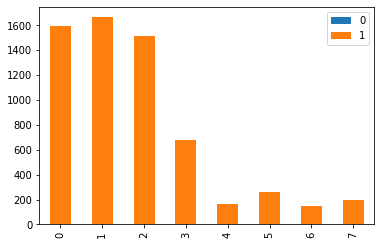

In [40]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Model building

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [42]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 32)                1376      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 1

In [43]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [44]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [45]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
35/73 [=============>................] - ETA: 0s - loss: 1.9130 - accuracy: 0.2679  
Epoch 1: val_loss improved from inf to 1.41564, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
73/73 [==============================] - 2s 9ms/step - loss: 1.7417 - accuracy: 0.2917 - val_loss: 1.4156 - val_accuracy: 0.5265
Epoch 2/1000
50/73 [===================>..........] - ETA: 0s - loss: 1.2159 - accuracy: 0.5512
Epoch 2: val_loss improved from 1.41564 to 0.92252, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
73/73 [==============================] - 0s 2ms/step - loss: 1.1443 - accuracy: 0.5782 - val_loss: 0.9225 - val_accuracy: 0.6544
Epoch 3/1000
41/73 [===============>..............] - ETA: 0s - loss: 0.8548 - accuracy: 0.6665
Epoch 3: val_loss improved from 0.92252 to 0.67352, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
73/73 [==============================] - 0s 3ms/step - loss: 0.8003 - accuracy: 0.6967 - val_loss: 

In [46]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [47]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

25/25 [==============================] - 0s 651us/step - loss: 0.0058 - accuracy: 0.9987


In [48]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.0000000e+00 6.5572679e-21 7.7562131e-19 1.2682189e-23 2.3290562e-22
 0.0000000e+00 4.3706344e-35 3.0306713e-29]
0


# Confusion matrix

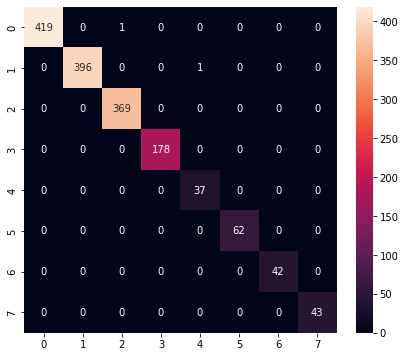

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      1.00      1.00       397
           2       1.00      1.00      1.00       369
           3       1.00      1.00      1.00       178
           4       0.97      1.00      0.99        37
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        43

    accuracy                           1.00      1548
   macro avg       1.00      1.00      1.00      1548
weighted avg       1.00      1.00      1.00      1548



In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [50]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [51]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\carmi\AppData\Local\Temp\tmpj7_rqmok\assets


7712

## Inference test

In [52]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [53]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [54]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [55]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 78.3 ms


In [56]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 1.6752429e-20 1.0421330e-18 2.7258716e-23 4.8919049e-22
 0.0000000e+00 1.1014968e-34 5.6748405e-29]
0


## Download model

In [57]:
!zip -r model.zip keypoint_classifier  

"zip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.




---


# ❗️Hyperparameters Tuning

In [58]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [59]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [60]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [61]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [62]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [63]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units_1': 16, 'num_units_2': 8, 'num_units_3': 8, 'dropout': 0.0, 'optimizer': 'adam'}
Epoch 1/50
50/73 [===================>..........] - ETA: 0s - loss: 2.0454 - accuracy: 0.1737 
Epoch 1: val_loss improved from inf to 1.91896, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
73/73 [==============================] - 1s 5ms/step - loss: 2.0184 - accuracy: 0.1986 - val_loss: 1.9190 - val_accuracy: 0.3049
Epoch 2/50
54/73 [=====================>........] - ETA: 0s - loss: 1.8302 - accuracy: 0.3828
Epoch 2: val_loss improved from 1.91896 to 1.62261, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
73/73 [==============================] - 0s 2ms/step - loss: 1.7964 - accuracy: 0.4160 - val_loss: 1.6226 - val_accuracy: 0.5937
Epoch 3/50
52/73 [====================>.........] - ETA: 0s - loss: 1.5005 - accuracy: 0.5922
Epoch 3: val_loss improved from 1.62261 to 1.25031, saving model to model/keypoint_classifier\keypoint_cla

In [64]:
# !ATTENTION! Works only in Colab
%tensorboard --logdir logs/hparam_tuning

Launching TensorBoard...

In [65]:
!rm -rf logs

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
